In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

data_path = "/content/drive/My Drive/SA/data"
model_path = "/content/drive/My Drive/SA/model"

In [ ]:
! pip install shap

     |████████████████████████████████| 327kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456472 sha256=b02e7177bfb40e6dacd4cfb7e53d8c5f616d59e1d7c64586974be60051aff81f
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
# Import needed libraries
import sys
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import itertools
from decimal import *

import xgboost
import shap

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv2D, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from sklearn.preprocessing import normalize

In [ ]:
features = np.load(os.path.join(data_path, 'coilfeatures_v7_6.npy'), allow_pickle=True, fix_imports=True, encoding='latin1')[:, 1:]
targets = np.load(os.path.join(data_path, 'coiltargets_v7_6.npy'))

In [ ]:
for f in range(features.shape[0]):
    features[f, 3] = float(features[f, 3])
    
features = features.astype(np.float16)


In [ ]:
features_norm = normalize(np.nan_to_num(features), norm='l2', axis=0, copy=True, return_norm=False)
# targets_norm = normalize(np.nan_to_num(targets), norm='l2', axis=0, copy=True, return_norm=True)


In [ ]:
clf = keras.models.load_model(os.path.join(model_path, 'dnn_v1_hgroup_6.h5'))


In [ ]:
train_data = np.expand_dims(features_norm, axis=1)
y = clf.predict(train_data)

In [ ]:
# select a set of background examples to take an expectation over
n_samples = 500
background = train_data[np.random.choice(train_data.shape[0], n_samples, replace=False)]
background = np.reshape(background,(n_samples,369))

# explain predictions of the model on four images
e = shap.DeepExplainer(clf, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
td = np.reshape(train_data,(-1,369))

shap_values = e.shap_values(td[1:5])



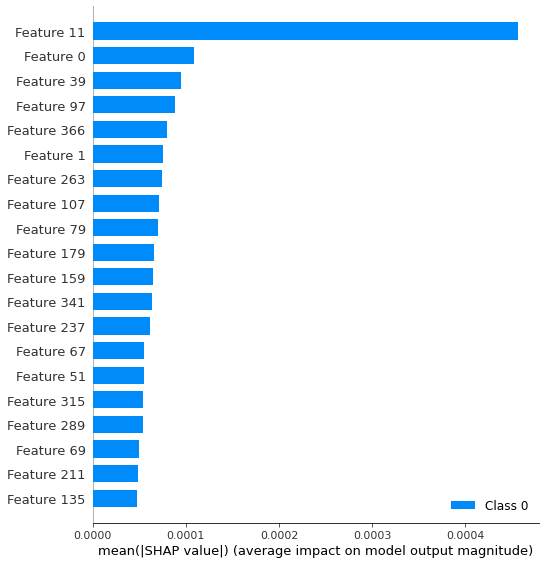

In [ ]:
shap.summary_plot(shap_values, td, plot_type="bar")

In [ ]:
shap.dependence_plot("RM", shap_values, td)

In [ ]:
td[0].shape

(369,)

In [ ]:
e.expected_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0002141], dtype=float32)>

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
# json.dumps(a.astype(float))
shap.force_plot(e.expected_value[0], shap_values[0][0], td[0])

In [ ]:
shap_values[0][0,:]

In [ ]:
background.shape

(100, 1, 369)

In [ ]:
train_data.shape

(255900, 1, 369)

In [ ]:
features.shape

(255900, 369)

In [ ]:
from keras.applications.vgg16 import preprocess_input
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
model = clf
e = shap.GradientExplainer(
    (model.input, model.output),
    map2layer(td, 1),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
